# Project description: "Creating a Data Pipeline for HappyPaws"

HappyPaws creates fun and educational apps for pet owners. 

HappyPaws wants to help pet owners understand their pets better by tracking their activities and health through the app. 

The data engineering team is responsible for making sure all the pet data from thousands of users is organized and safe, so pet owners can get tips to keep their pets happy and healthy.



## Task

HappyPaws has collected three datasets over the past year: 
 - "pet_activities.csv" which logs daily activities of pets, 
 - "pet_health.csv" which records vet visits and health issues, and 
 - "users.csv" which contains information about the pet owners. 

Each dataset contains unique identifiers for pets and/or their owners. 

The engineers developing the app currently write code to cross reference all of these data sources. 

They want to make things easier by having a single table with all data included.

Your manager has asked you to write a Python function that cleans and merges these datasets into a single dataset. 

The final dataset should provide a comprehensive view of each pet's activities, health records, and owner information. 

- To test your code, your manager will run only the code `all_pet_data('pet_activities.csv', 'pet_health.csv', 'users.csv')`
- Your `all_pet_data()` function must return a DataFrame, with columns as described below.
- All columns must accurately match the descriptions provided below, including names.

## Data

The data that has been provided has the following structure

![image](../assets/image.png)

The function that you write must return data as described below. There should be a unique row for each activity/health visit. 

Where missing values are permitted, they should be in the default Python format.

|Column Name | Description |
|-------|-------|
| pet_id | Unique identifier for each pet. There should not be any missing values.|
| date | The date of the activity recorded or the date of the health visit, in date format. There should not be any missing values.|
| activity_type | The type of activity, one of 'Walking', 'Playing', 'Resting' or for rows that relate to a health visit, the value 'Health'. Missing values are permitted.|
| duration_minutes | The duration of the activity in minutes. For rows that relate to health visits, this should be 0. Missing values for other activities are permitted.|
| issue | The health issue identified or check-up note. For rows that relate to activities, this should be a missing value. Missing values for health activities are permitted.|
| resolution | The outcome or advice given for the issue. For rows that relate to activities, this should be a missing value. Missing values for health activities are permitted.|
| owner_id | Unique identifier for the pet owner. All pets must have an owner.|
| owner_age_group | The age group of the owner (e.g., 18-25, 26-35, etc.). Missing values are permitted.|
| pet_type | The type of pet (e.g., Dog, Cat). Missing values are permitted.|

# Code

## Imports

In [24]:
# Imports
import seaborn as sns
from utilities.processes import all_pet_data
from utilities.config import data
import utilities.visuals as visuals

## Data preparation

**Data is prepared by:** 

*Cleaning:*
- removing records that have no `pet_id` or `date` 
- converting data types to an appropriate type
- assigning appropriate placeholders (typically `null`) for missing values in `duration_minutes`, `issue`, `resolution`, `owner_age_group`, and `pet_type`
- sorting columns

**Merging:* 
- Merging the activities data with the health data and merging the resultant dataset with the users data

In [25]:
cleaned = all_pet_data(sort=True)
cleaned.to_csv(data / 'cleaned.csv', index=False)

## Inspection and visualization

### Metadata

In [26]:
# Metadata of cleaned data
print(cleaned.dtypes)
display(cleaned.describe(include='all'))

pet_id                       int64
date                datetime64[ns]
activity_type             category
duration_minutes           float64
issue                     category
resolution                category
owner_id                     int64
owner_age_group           category
pet_type                  category
dtype: object


,pet_id,date,activity_type,duration_minutes,issue,resolution,owner_id,owner_age_group,pet_type
count,1878.000000,1878,1878,1691.000000,940,940,1878.000000,1878,1878
unique,NaN,NaN,4,NaN,4,8,NaN,6,5
top,NaN,NaN,Health,NaN,Annual Checkup,"Cleaning done, no dental issues",NaN,26-35,Fish
freq,NaN,NaN,940,NaN,479,200,NaN,350,417
mean,5159.256656,2023-02-13 17:15:54.632588032,NaN,20.086339,NaN,NaN,4915.624601,NaN,NaN
min,9.000000,2022-04-01 00:00:00,NaN,0.000000,NaN,NaN,12.000000,NaN,NaN
25%,2794.000000,2022-09-11 06:00:00,NaN,0.000000,NaN,NaN,2313.500000,NaN,NaN
50%,5288.000000,2023-02-08 00:00:00,NaN,0.000000,NaN,NaN,4945.000000,NaN,NaN
75%,7757.000000,2023-07-26 00:00:00,NaN,40.000000,NaN,NaN,7472.000000,NaN,NaN
max,9988.000000,2023-12-30 00:00:00,NaN,90.000000,NaN,NaN,9972.000000,NaN,NaN


### Distribution of pets

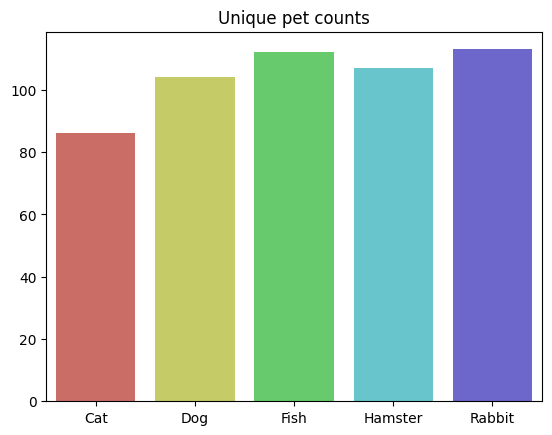

In [27]:
sns.set_palette('hls')
visuals.pet_counts(cleaned, save=True)

#### Distribution of pets by owner age groups

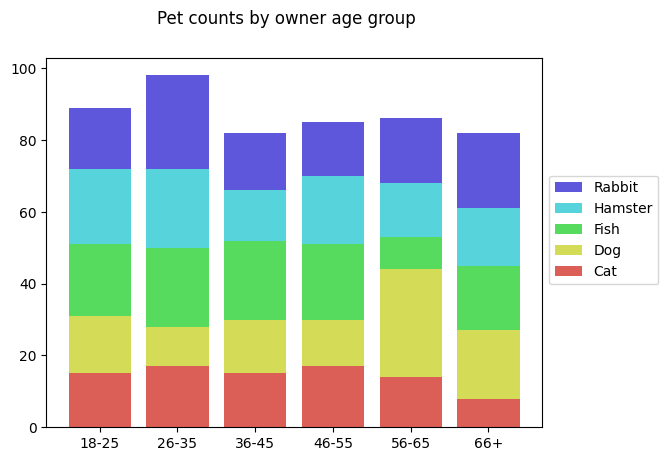

In [28]:
visuals.pet_counts_by_owner_age(data=cleaned, save=True)

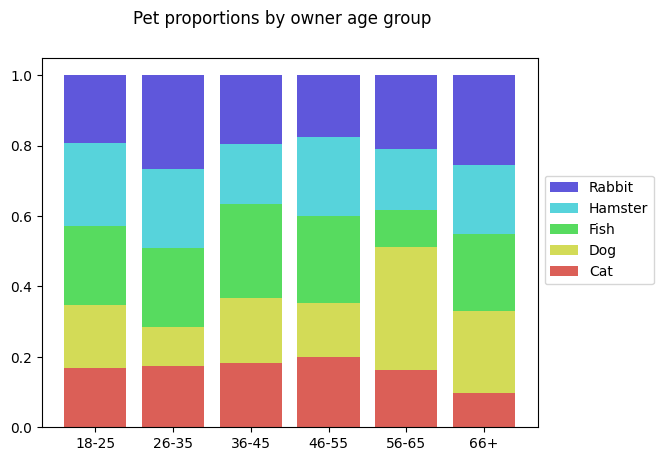

In [29]:
visuals.pet_counts_by_owner_age(data=cleaned, save=True, proportions=True)    

A quick analysis of pet distributions shows that rabbits and fish are the most common occurring pet types among app users while cats are the least commonly occuring one.

The age most commonly using the app register in the 26-35 age.

Among different age groups, proportions for each pet type are fairly stable except for a few places:
- Rabbits seem popular amoung 26-35 and 66+
- Fish are not very popular among 56-65
- Dogs are not very popular among 26-35 but very popular among 56-65
- Cats are not very popular among 66+

### Health activities
#### Distribution of health activities per month

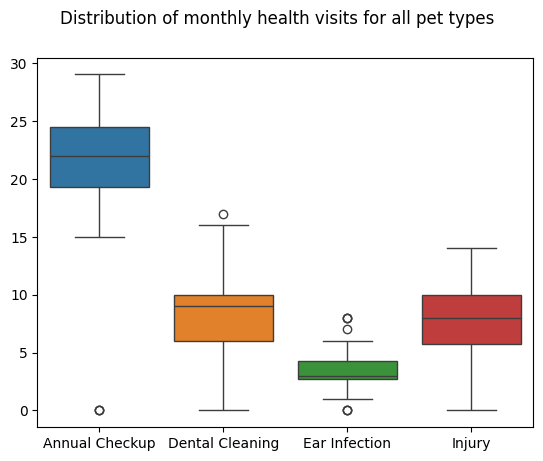

In [30]:
sns.set_palette('tab10')
visuals.health_activities_boxplots(cleaned, save=True)

For recorded health activities, "annual checkups" are by far the most commonly recorded event, averaging around 22 records per month with a minimum of at least 15. "Dental cleaning" and "injury" are similar to each other, averaging 8-9 per month, while "ear infections" average around 4. Surprisingly, some months do go without any injuries.

##### By pet type

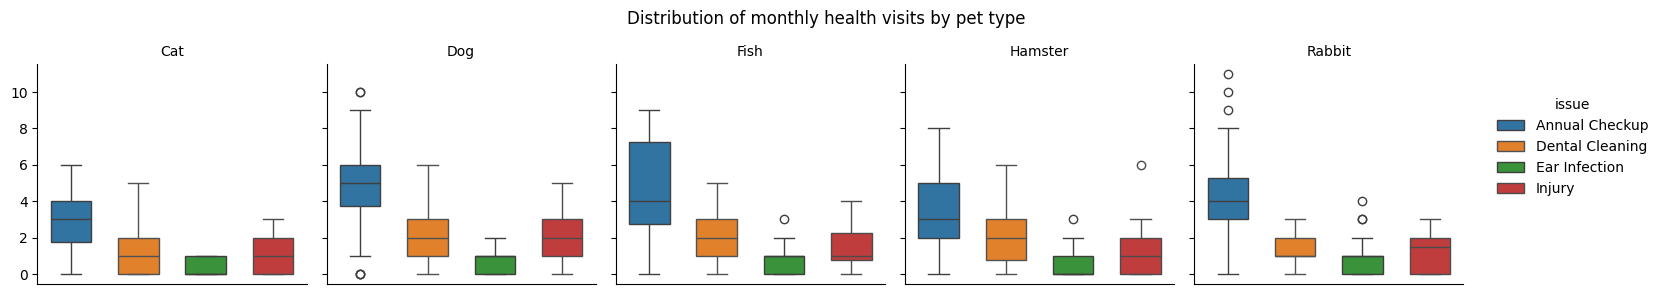

In [31]:
visuals.health_activities_boxplots(cleaned, by_type=True, save=True)


When broken down by pet type, health visits stay fairly consistent per type, except:
- annual checkups with cats and dogs
- dental cleanings with rabbits

#### Time between health visits
##### Annual checkups

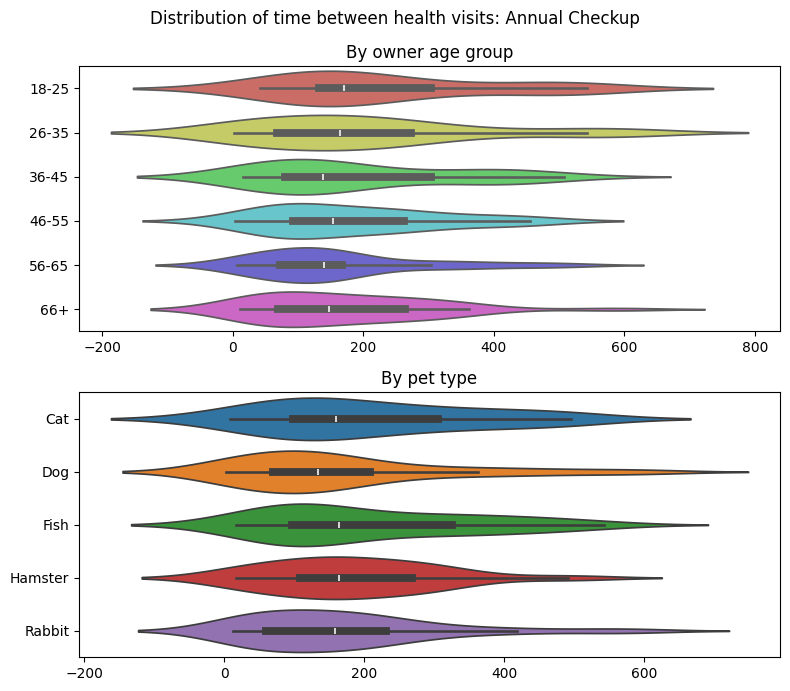

In [32]:
visuals.activities_elapsed_time_distributions(cleaned, group_by='both', save=True, plot_type='violin', palette=['hls', 'tab10'])    

On average, annual checkups happen every 160-180 days, with dogs seeing the vet more often than other pet types and owners aged 36-45 and 56-65 scheduling vet visits more often. Fish and cats see the most time between vet visits, as do owners aged 18-25.

#### Health activities over time

##### By pet type

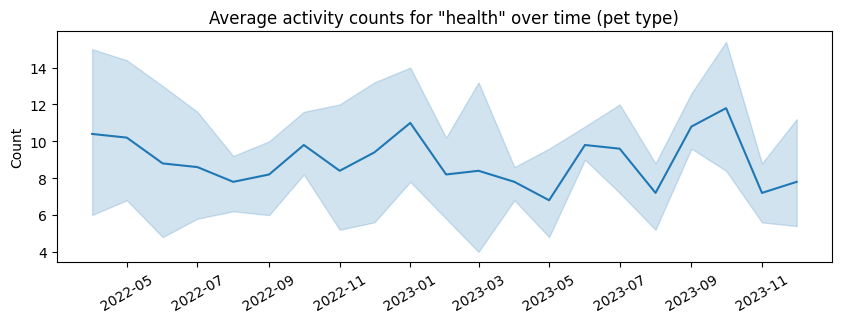

In [33]:
visuals.activities_time_series(cleaned)

##### By owner ages

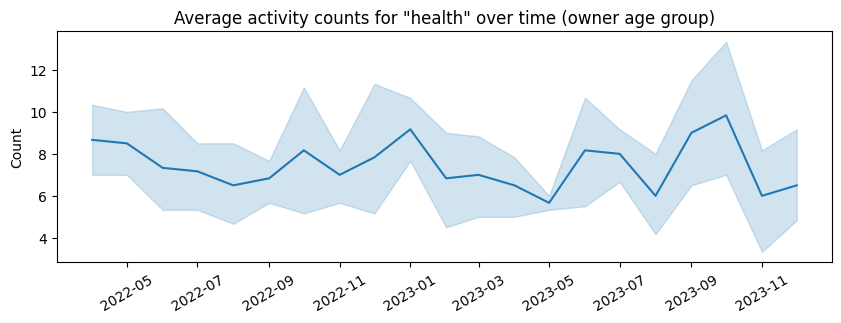

In [34]:
visuals.activities_time_series(cleaned, group_by='owner ages')

Average counts per month for health activity see similar trends in the average, though the spread of counts starts tighter for owners and stays fairly consistent, compared to pet type. Differences in counts per month are explained by the difference in number of groups when calculating the mean for that month.

### Non-health activities

#### Counts

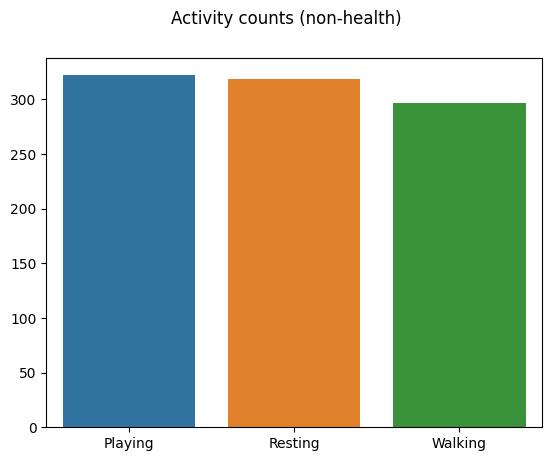

In [35]:
visuals.activities_countplots(data=cleaned, save=True)

"Play" is the most recorded non-health activity, but not by much.

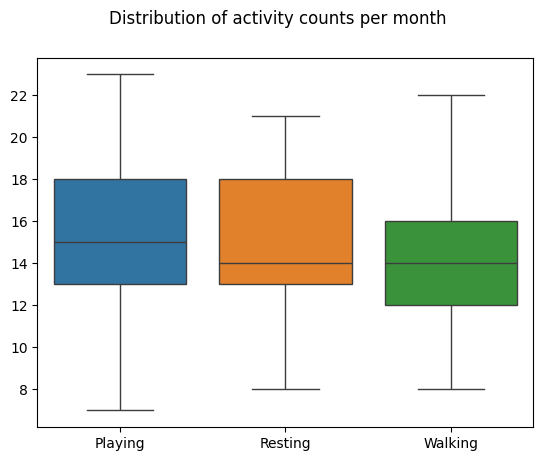

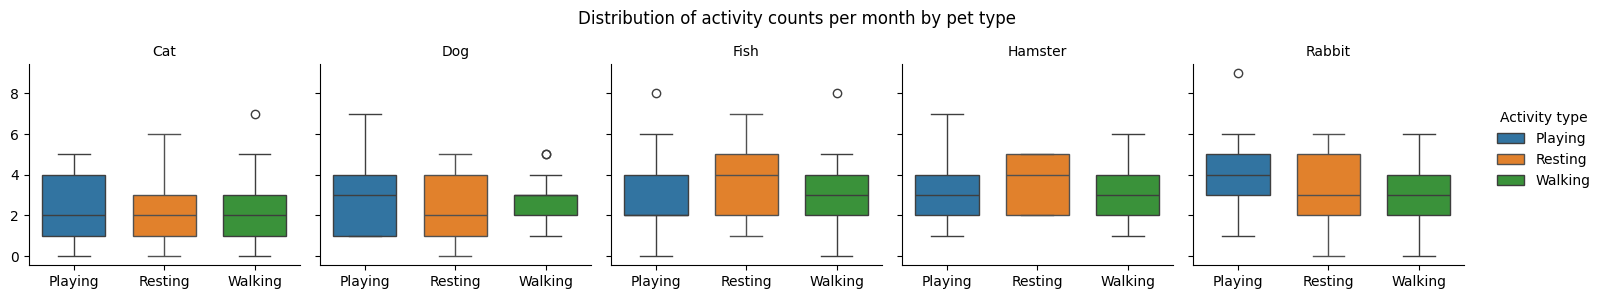

In [36]:
visuals.activities_boxplots(cleaned, save=True)
visuals.activities_boxplots(cleaned, by_type=True, save=True)

The distributions reveal nothing very interesting, with all pet types closely mirroring the overall distribution.

<!-- 
Some questions arise from this visualization:
- Why are there so many counts for "fish" and "walking"?
- 'Walking' for dogs seems low: why is that?
- What are pet owners or pets doing that counts as "playing", especially for fish, hamsters, and rabbits?

--> 

#### Durations

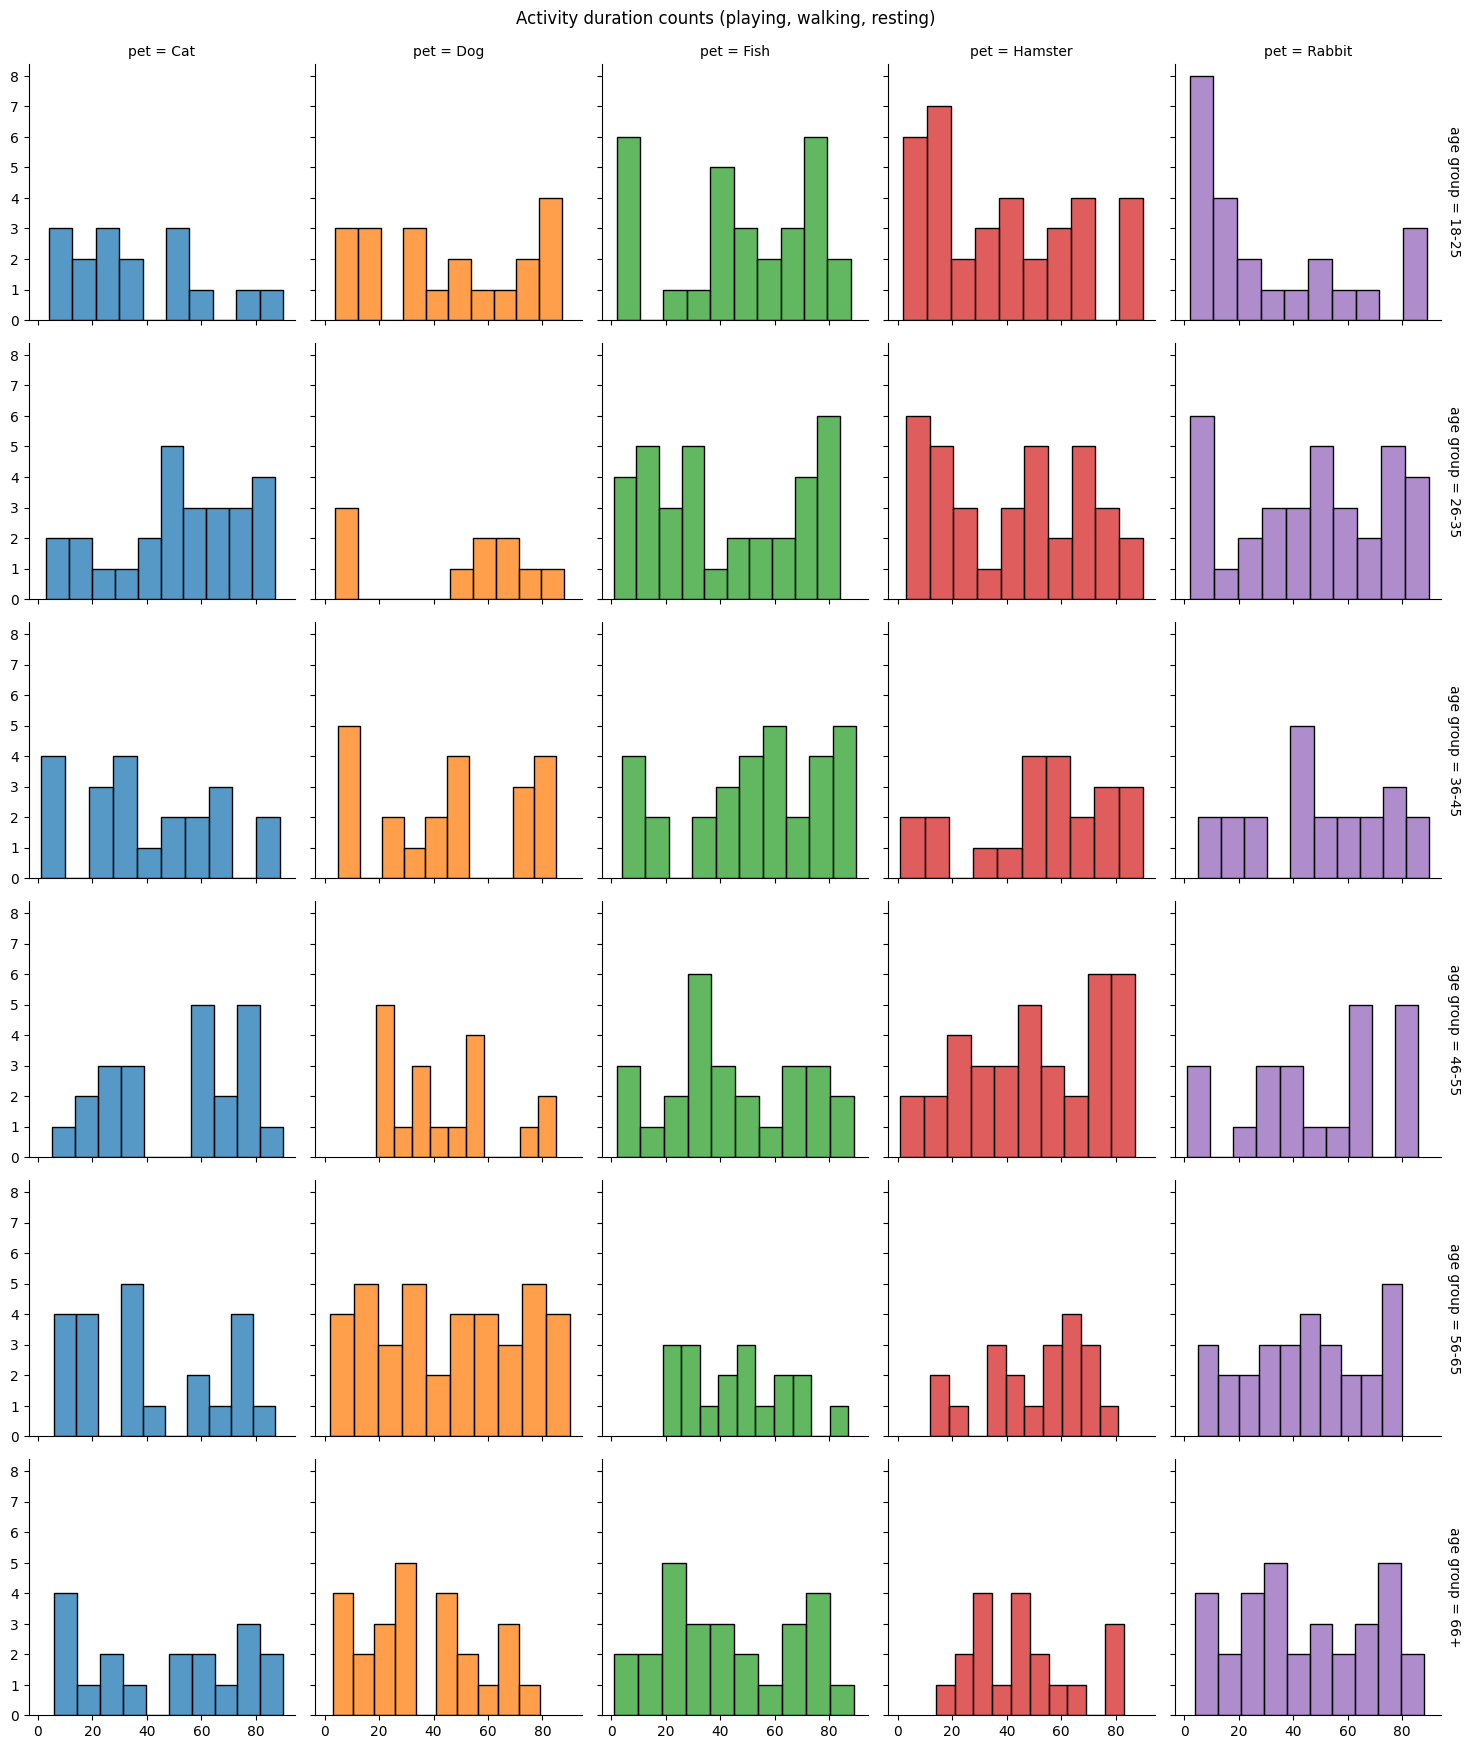

In [37]:
visuals.activities_duration_counts_grid(cleaned)


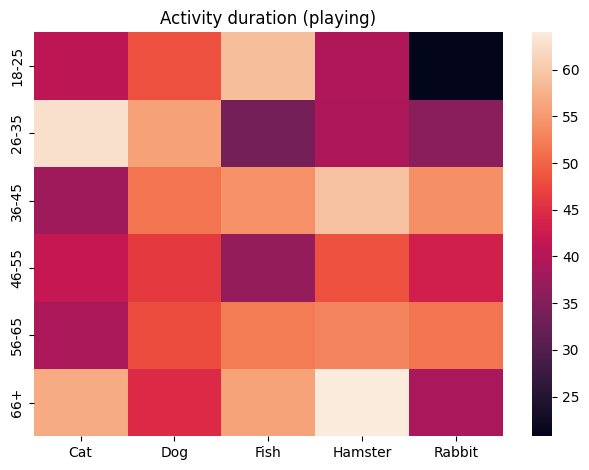

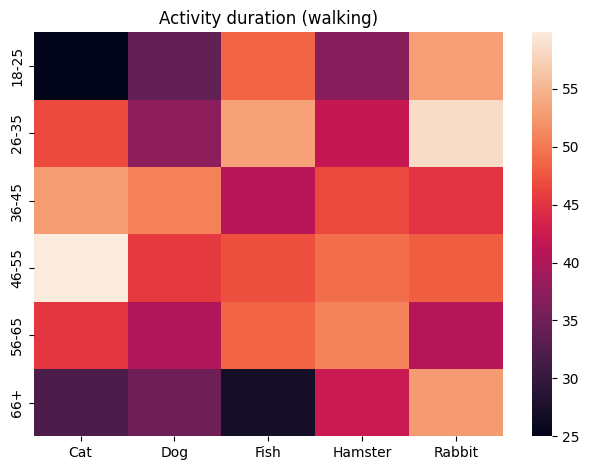

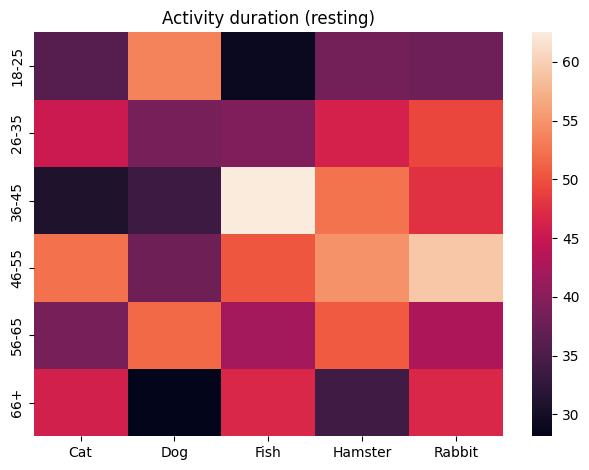

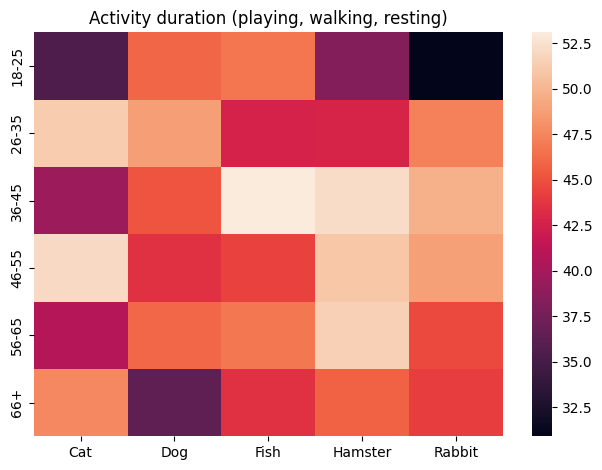

In [38]:
activities = ['playing', 'walking', 'resting']
for activity in activities:
    visuals.activities_duration_means_heatmap(cleaned, activity)
visuals.activities_duration_means_heatmap(cleaned, ','.join(activities))

There do not appear to be any striking trends when comparing owner age groups and pet types for means of recorded non-health activity durations by activity.

When looking at "playing", though, it is interesting to see that owner age groups 36-45 and 56-65 are fairly consistent and clustered for all pet types except cats.

When looking at all activities, it is interesting to note that hamsters consistently score above 50 minutes for owners aged 36-65. Also, rabbits have tighter clustering for all age groups except 18-25 while dogs have tighter clustering than other pet types for all age groups except 66+.

#### Average monthly activities

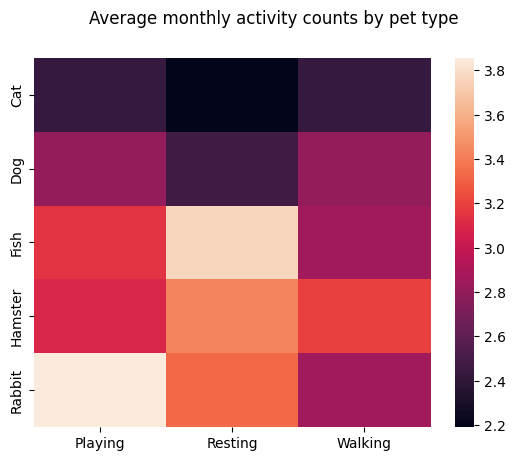

In [39]:
visuals.activities_heatmaps(cleaned, category='pets', save=True);

Among all pet types, fish and rabbits see the most activity records with "resting" and "playing", respectively.
Cats see the lowest record counts with "resting". Interestingly, hamsters see the highest record counts for walking and rabbits for playing.

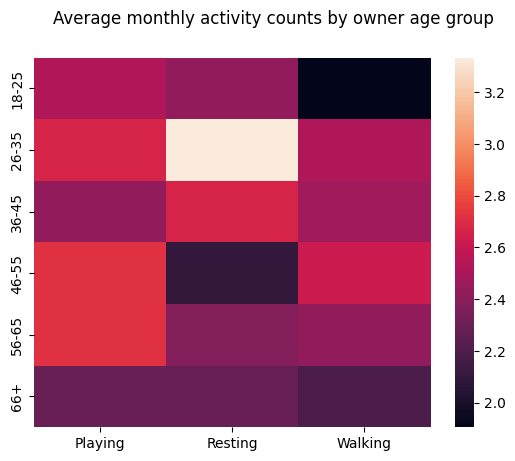

In [40]:
visuals.activities_heatmaps(cleaned, category='owners', save=True);

Among owner age groups, the 26-35 bracket record "resting" most often each month, while the 18-25 group record "walking" the least.

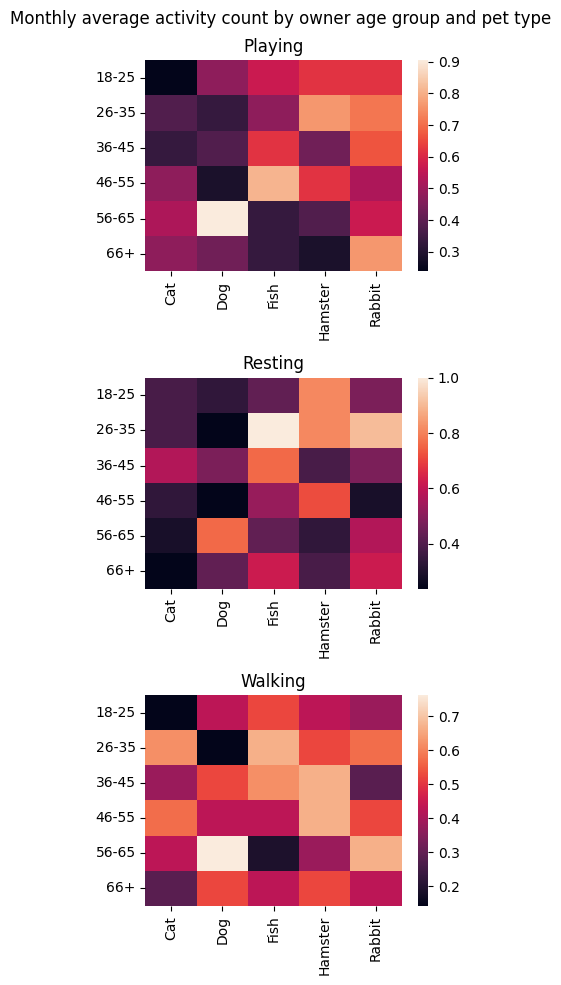

In [41]:
visuals.activities_heatmaps_owners_pets(cleaned, save=True);

When broken down by non-health activity and compared across owner ages and pet types, we can see that dogs with owners in the 55-65 age group are the most common pairing for walking **and** playing.

Meanwhile, dogs with owners aged 26-35 and cats with owners aged 18-25 see the fewest records for walking. The lowest counts for playing are (dogs, 46-55), (cats, 18-25), and (hamsters, 66+).

When it comes to resting, (fish, 26-35) see the most app activity while (cats, 66+), (dogs, 26-35), (dogs, 46-55) and (rabbits, 46-55) see the least app activity.

#### Average time between non-health records

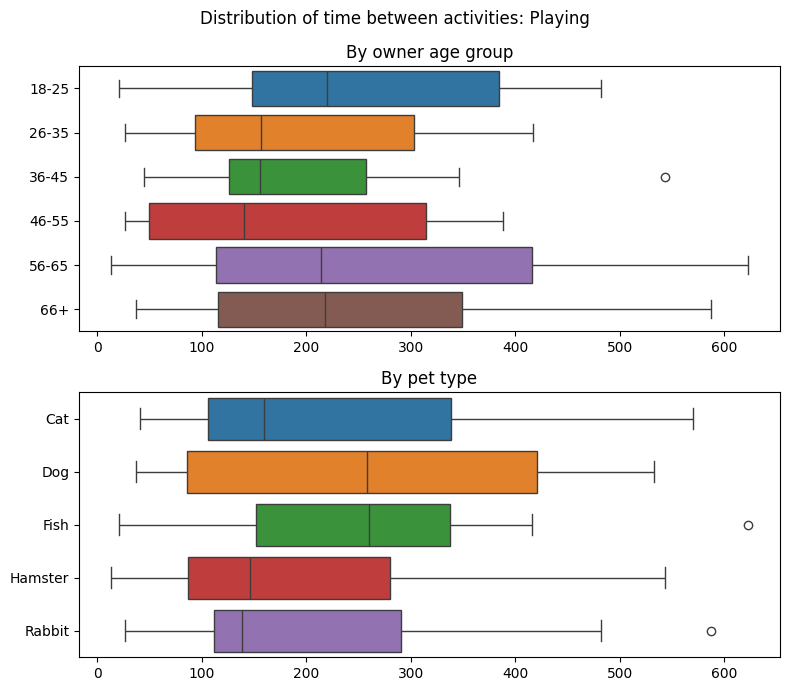

In [42]:
visuals.activities_elapsed_time_distributions(cleaned, activity='playing', group_by='both')

Looking at non-health activities, we see the lowest amount of time between records (app use) by owners between the ages of 26 and 55, averaging under 150 days; the other age groups average over 200 days. The most variance is among owners aged 56 and older while the most consistent age group is 36-45.

When it comes to pet types, cats, hamsters, and see activity most often while dogs and fish see it less often. The most varied lull happens among cat owners while fish owners exhibit the most consistent behavior.

#### Average playtime counts by owner age group and pet type over time 

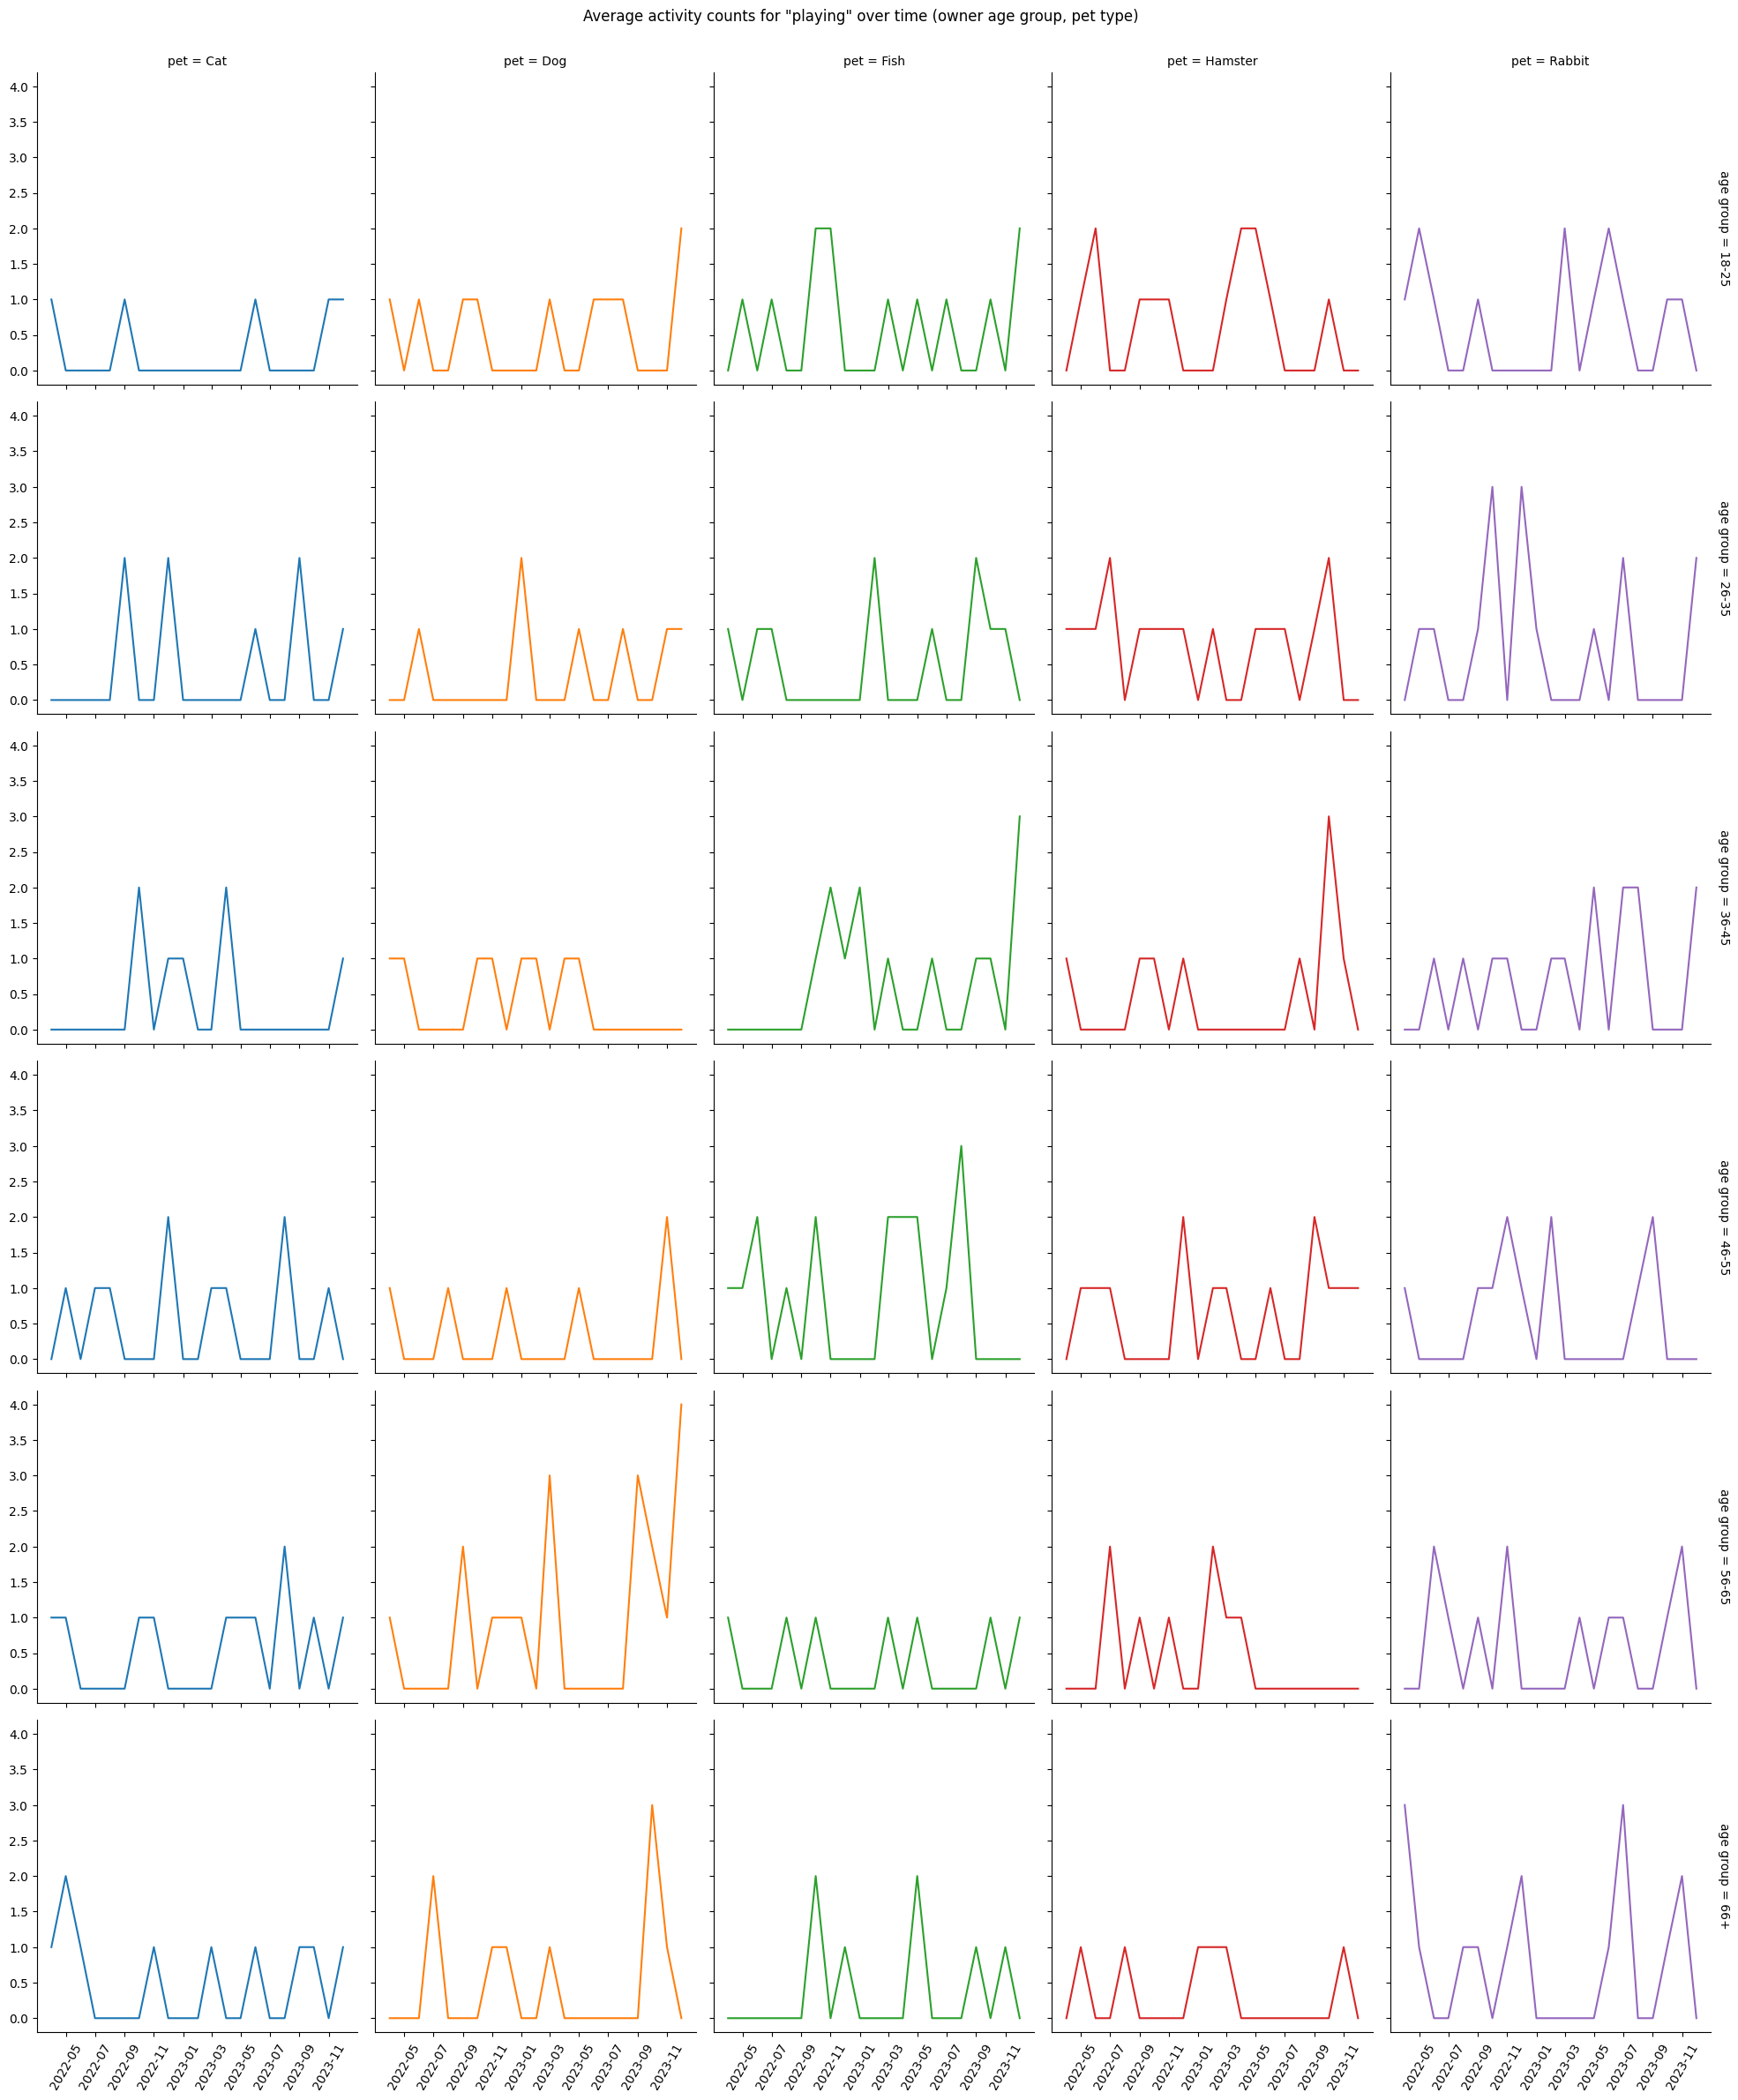

In [43]:
visuals.activities_time_series(cleaned, activity='playing', explode=True)

When looking at records for playing, all pet types and all owner age groups see peaks and lulls in recording behavior throughout the period examined.

# Analysis

*This report can also be found as a file in the `products` directory [(link)](../products/report.md).*

*The Data*

This analysis was conducted on data supplied by HappyPaws from their app between April 1, 2022 and December 30, 2023, a period of 21 months. This dataset contains records for 1878 pet owners, each recording for a single pet. Pet type, pet activities of health and non-health oriented varieties were recorded, as were owner ages, activity durations, and resolutions for health issues.

*Observations*

Pet ownership among users of this app is dominated by those who own fish, hamsters, and rabbits. This contrasts with the statistics of the American Veterinary Medical Association, which has dog and cat proportions at 46% and 32%, respectively; meanwhile, fish (2.9%), hamsters (1%) and rabbits (0.7%) rank fairly low in terms of ownership shares.

By age group, pet ownership is fairly consistent, proportionally. The only interesting groups are:
- rabbits, which are popular among owner age groups 26-35 and 66 and older
- cats, which enjoy less popularity in the 66 and older crowd
- and the 56-65 age group who favor dogs at higher rates and fish at lower rates than the rest of the owner ages groups or pet types

For planned health activities, annual checkups make roughly half of medical records in the app, on average. This holds by pet type, mostly.
Zooming in on annual checkups, I found that records for dogs were submitted more often than other pet types while cats and fish saw the longest lull between records. Duration between records was fairly consistent among different age groups.
Additionally health activities were recorded fairly consistently per month over the period examined.


When looking at non-health activities ("playing", "walking", "resting"), playing was the most common activity recorded but not by much over the other activities. This held true by pet type.

Analyzing activity durations yielded very little interesting information that was not already obvious from other visualizations (e.g. fish get quite a bit of "walking" and "playing" time).

Looking at these activities by owner age group and pet type, I found that dogs and cats were pet types that saw average activity counts per month that were more consistently lower while fish, hamsters, and rabbits were more consistent across the age groups. It is worth noting that, for playing and walking, the (dogs, 56-65) age group shines in record counts, though that may be due to sheer volume.

Distribution of durations between records for these activities clustered around two values for different groups. For pet types, cats, rabbits, and hamsters saw records around every 130-150 days, on average, while dogs and fish saw closer to every 275 days, on average. For owner age groups, groups between 26 and 55 clustered around 130 days, while the other age groups clustered around 220 days.

When focusing on duration between playtime records, there were no striking trends other than that there are many lulls and peaks for all pairings of pet type and owner age group across the time period examined. And, sometimes, these lulls lasted for consecutive months.

## Recommendations

To increase app use and consistency of app use, a few things should be done.

Engagement with cat and dog owners is very low, relative to the American population. Campaigns to engage with these groups need to be mounted, which would increase overall user volume.

Efforts to encourage owners to record activities more often should be undertaken. It is hard to imagine that owners do not interact with pets for months at a time, so it must be that they are not using the app very often. Creating incentives to record more often should be considered, as well as instituting reminders or alarms in the app.

Walking and playing saw high counts among animals that were not dogs or cats, which is interesting (especially as regards fish!). An effort should be made to see what owners are experiencing or doing when they make these records, to understand how owners are interacting with the app. Furthermore, it would be useful to find out what specific kinds of activities owners are classing into "playing", "resting", and "walking" and what criteria they use to make that determination. Offering sub-activities to choose from would improve data quality and might yield more interesting data about activity durations.

Other things that could improve data quality include:
- composition of owner households: are these single people, families, childless couples?
- whether these app users are single-pet households
- pet ages